# Ứng dụng của mạng DNN

Thời lượng ước tính: **60** phút


Bạn hoàn thành phần này cũng là hoàn thành phần cuối cùng của lab 4.
Bạn sẽ sử dụng các hàm đã triển khai trong lab trước đó để xây dựng một mạng sâu và áp dụng nó để phân loại mèo và không phải mèo. Hy vọng rằng bạn sẽ thấy sự cải thiện về độ chính xác so với việc triển khai hồi quy logistic trước đây của mình.

**Sau lab này, bạn sẽ có thể:**
- Xây dựng và áp dụng mạng nơ ron sâu (deep neural network) cho việc học có giám sát (supervised learning).

Hãy bắt đầu nào!

## 1 - Thư viện

Đầu tiên, hãy nhập tất cả các thư viện mà chúng ta sẽ cần trong lab này.
- [numpy](www.numpy.org) là thư viện cơ bản cho tính toán khoa học trong Python.
- [matplotlib](http://matplotlib.org) là một thư viện để vẽ đồ thị trong Python.
- [h5py](http://www.h5py.org) là một thư viện phổ biến để tương tác với tập dữ liệu được lưu trữ trên tệp H5.
- [PIL](http://www.pythonware.com/products/pil/) và [scipy](https://www.scipy.org/) được sử dụng ở đây để kiểm tra mô hình của bạn với hình ảnh ở cuối .
- dnn_app_utils cung cấp các hàm được triển khai trong lab "Xây dựng mạng nơ-ron sâu của bạn: Từng bước" vào notebook này.
- np.random.seed(1) được sử dụng để giữ cho tất cả các lệnh gọi hàm ngẫu nhiên nhất quán. Nó sẽ giúp chúng tôi đánh giá bài làm của bạn.

In [ ]:
import time
import numpy as np
import h5py
import matplotlib.pyplot as plt
import scipy
from PIL import Image
from scipy import ndimage
from dnn_app_utils_v2 import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # đặt kích thước mặc định của biểu đồ
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1)

## 2 - Tập dữ liệu

Chúng ta sẽ sử dụng tập dữ liệu "Cat vs non-Cat". Mô hình bạn đã xây dựng có độ chính xác thử nghiệm 70% về phân loại hình ảnh là mèo và không phải mèo. Hy vọng rằng mô hình mới của bạn sẽ hoạt động tốt hơn!

**Trình bày bài toán**: Cho tập dữ liệu ("data.h5") chứa:
    - tập huấn luyện hình ảnh m_train được dán nhãn cat (1) hoặc non-cat (0)
    - tập thử nghiệm hình ảnh m_test được dán nhãn cat và non-cat
    - mỗi ảnh có shape (num_px, num_px, 3) trong đó 3 là 3 kênh (RGB).

Hãy làm quen với tập dữ liệu. Tải dữ liệu bằng cách chạy cell bên dưới.

In [ ]:
train_x_orig, train_y, test_x_orig, test_y, classes = load_data()

Đoạn code sau sẽ hiển thị cho bạn một hình ảnh trong tập dữ liệu. Hãy tùy ý thay đổi chỉ mục và chạy lại cell nhiều lần để xem các hình ảnh khác.

y = 0. It's a non-cat picture.


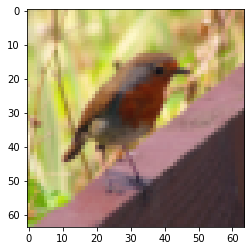

In [ ]:
# Hình ảnh ví dụ
index = 10
plt.imshow(train_x_orig[index])
print ("y = " + str(train_y[0,index]) + ". It's a " + classes[train_y[0,index]].decode("utf-8") +  " picture.")

In [ ]:
# Khám phá tập dữ liệu
m_train = train_x_orig.shape[0]
num_px = train_x_orig.shape[1]
m_test = test_x_orig.shape[0]

print ("Number of training examples: " + str(m_train))
print ("Number of testing examples: " + str(m_test))
print ("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_x_orig shape: " + str(train_x_orig.shape))
print ("train_y shape: " + str(train_y.shape))
print ("test_x_orig shape: " + str(test_x_orig.shape))
print ("test_y shape: " + str(test_y.shape))

Number of training examples: 209
Number of testing examples: 50
Each image is of size: (64, 64, 3)
train_x_orig shape: (209, 64, 64, 3)
train_y shape: (1, 209)
test_x_orig shape: (50, 64, 64, 3)
test_y shape: (1, 50)


Như thường lệ, chúng ta sẽ định hình lại và chuẩn hóa các hình ảnh trước khi đưa chúng lên mạng. Code được đưa ra trong cell bên dưới.

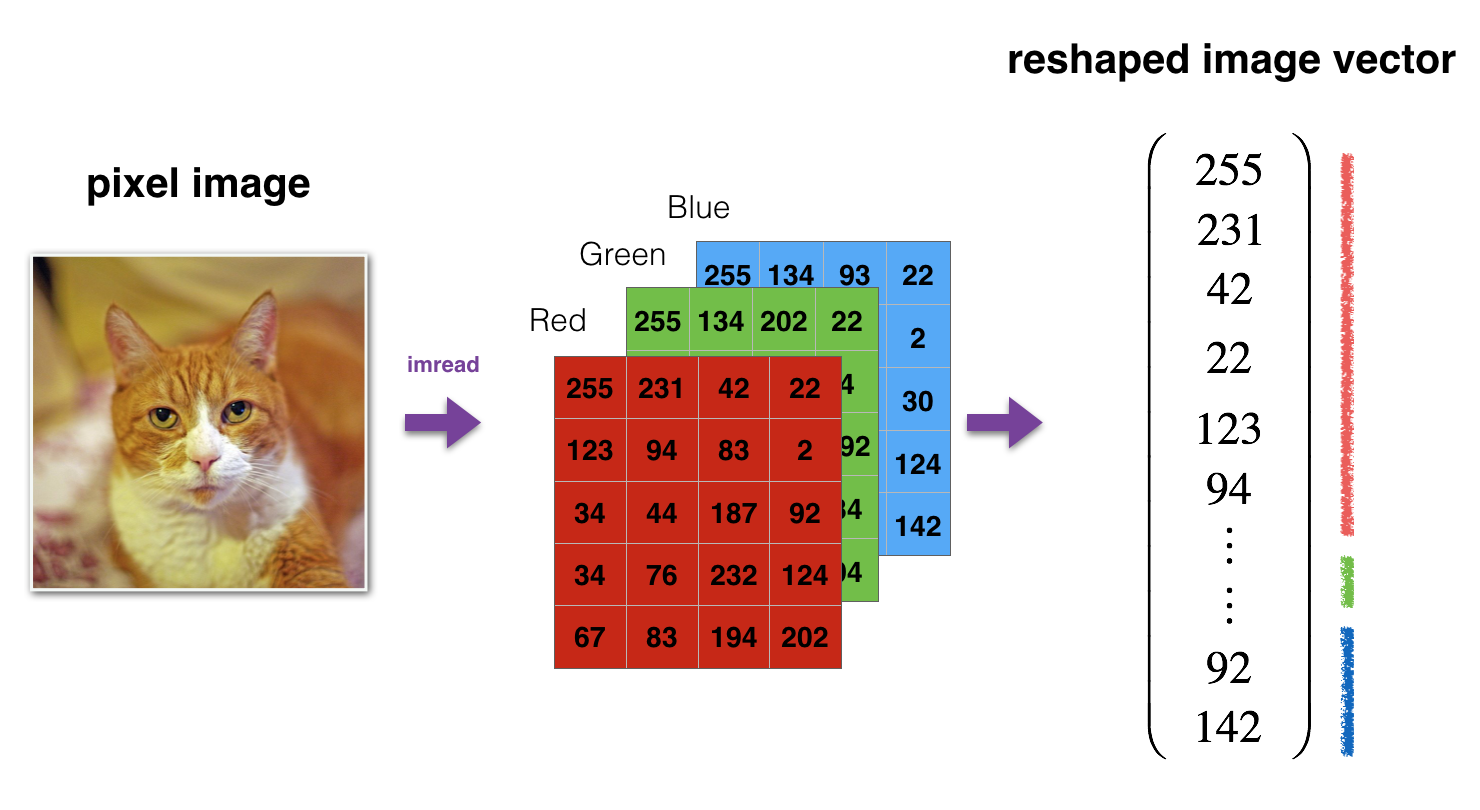
**Hình 1**: Chuyển ảnh sang vectơ.

In [ ]:
# Định hình lại các ví dụ huấn luyện và kiểm tra
train_x_flatten = train_x_orig.reshape(train_x_orig.shape[0], -1).T   # "-1" làm cho định hình lại làm phẳng các dimension còn lại
test_x_flatten = test_x_orig.reshape(test_x_orig.shape[0], -1).T

# Chuẩn tắc hóa dữ liệu để có các giá trị nằm trong khoảng 0 và 1.
train_x = train_x_flatten/255.
test_x = test_x_flatten/255.

print ("train_x's shape: " + str(train_x.shape))
print ("test_x's shape: " + str(test_x.shape))


train_x's shape: (12288, 209)
test_x's shape: (12288, 50)


$12,288$ = $64 \times 64 \times 3$ là kích thước của một vectơ hình ảnh được định dạng lại.

## 3 - Kiến trúc mô hình

Bây giờ bạn đã quen thuộc với tập dữ liệu, đã đến lúc xây dựng một mạng lưới nơ-ron sâu để phân biệt hình ảnh là mèo với ảnh không phải mèo.

Bạn sẽ xây dựng 2 mô hình khác nhau:
- Mạng nơ-ron 2 lớp
- Mạng nơ-ron sâu L lớp

Sau đó, bạn sẽ so sánh hiệu suất của các mô hình này và cũng có thể thử các giá trị khác nhau cho $L$. 

Chúng ta hãy nhìn vào hai kiến ​​trúc.

### 3.1 - Mạng nơ-ron 2 lớp

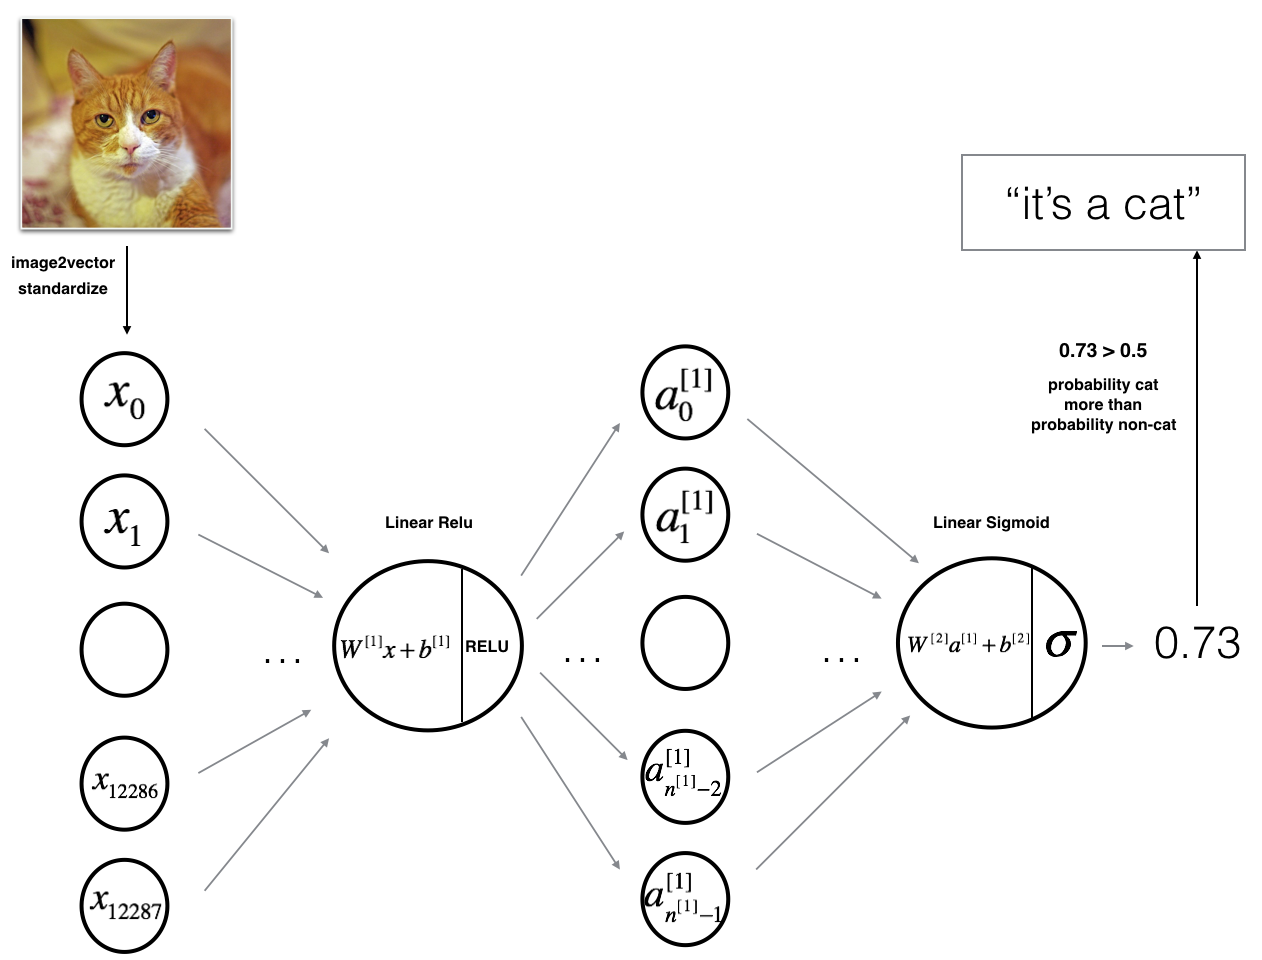
**Hình 2**: Mạng nơ-ron 2 lớp. <br> Mô hình có thể được tóm tắt như sau: ***INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT***.

<u>Kiến trúc chi tiết của Hình 2</u>:
- Đầu vào là hình (64,64,3) được làm phẳng thành vectơ có kích thước $(12288,1)$. 
- Vectơ tương ứng: $[x_0,x_1,...,x_{12287}]^T$ is sau đó được nhân với ma trận trọng số $W^{[1]}$ có kích thước $(n^{[1]}, 12288)$.
- Sau đó, thêm một bias term và lấy relu của nó để nhận được vectơ sau: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Sau đó bạn lặp lại quy trình tương tự.
- Nhân vectơ kết quả với $W^{[2]}$ và thêm số chặn (bias) của mình. 
- Cuối cùng, lấy sigmoid của kết quả. Nếu lớn hơn 0.5, bạn phân loại nó thành cat (mèo).

### 3.2 - Mạng nơ-ron sâu L lớp

Thật khó để biểu diễn một mạng nơ-ron sâu L lớp với cách biểu diễn trên. Tuy nhiên, đây là một biểu diễn mạng được đơn giản hóa:

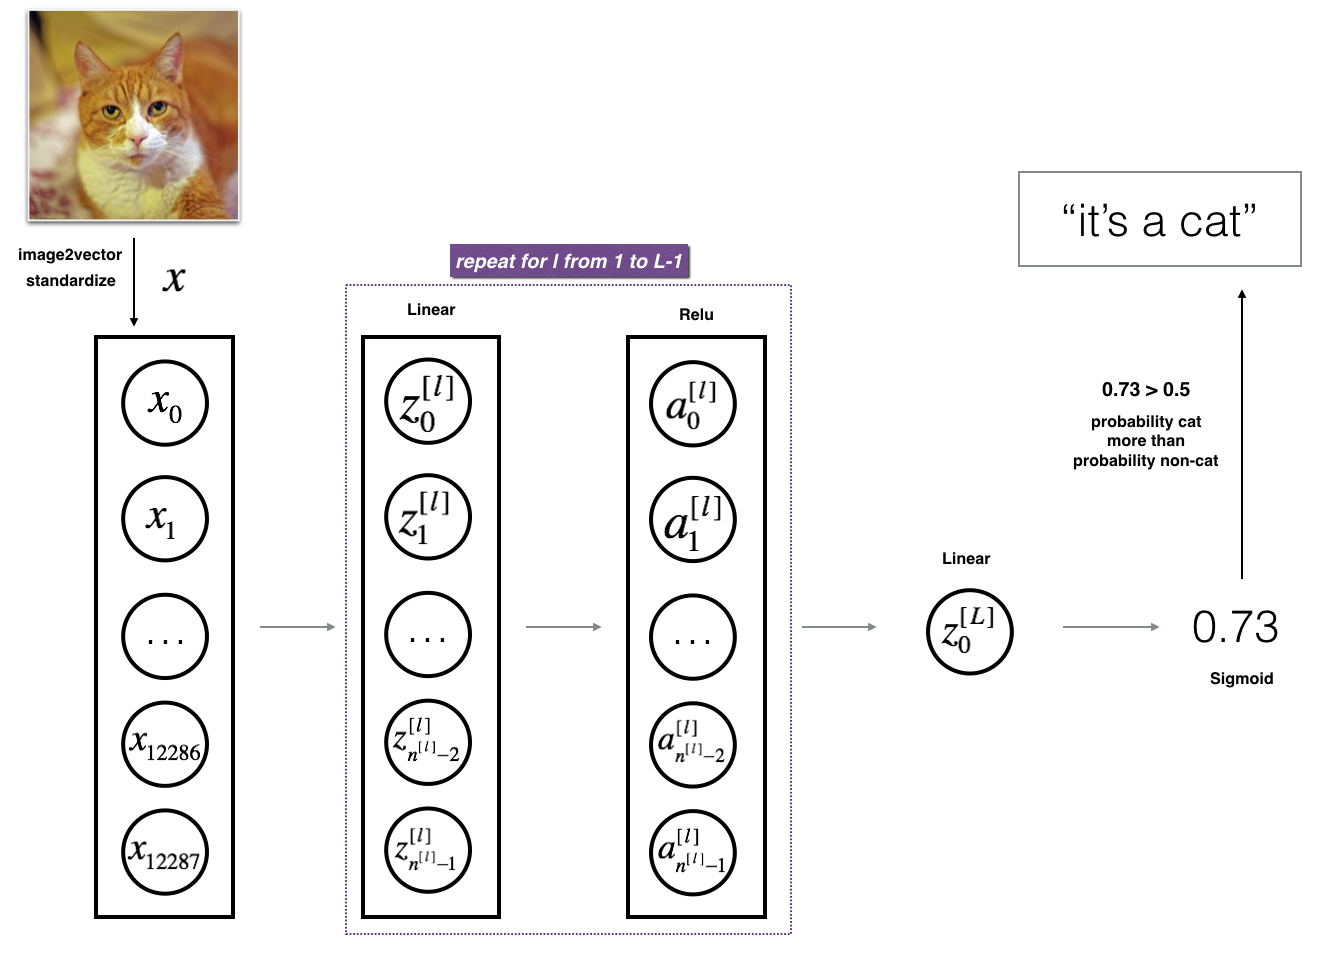
**Hình 3**: Mạng nơ-ron L-lớp. <br> Mô hình có thể được tóm tắt như sau: ***[LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID***</center></caption>

<u>Kiến trúc chi tiết của Hình 3</u>:
- Đầu vào là một hình ảnh (64,64,3) được làm phẳng thành một vector có kích thước (12288,1).
- Vectơ tương ứng: $[x_0,x_1,...,x_{12287}]^T$ is sau đó được nhân với ma trận trọng số $W^{[1]}$ và sau đó bạn thêm vào số chặn $b^{[1]}$. Kết quả được gọi là đơn vị tuyến tính.
- Tiếp theo, bạn lấy relu của đơn vị tuyến tính. Quá trình này có thể được lặp lại nhiều lần cho mỗi $(W^{[l]}, b^{[l]})$ tùy thuộc vào kiến ​​trúc mô hình.
- Cuối cùng, bạn lấy sigmoid của đơn vị tuyến tính cuối. Nếu lớn hơn 0,5, bạn phân loại nó thành cat.

### 3.3 - Phương pháp luận chung

Như thường lệ, bạn sẽ làm theo phương pháp Deep Learning để xây dựng mô hình:
    1. Khởi tạo tham số/Xác định siêu tham số (hyperparameter)
    2. Vòng lặp cho num_iterations:
        a. Lan truyền xuôi
        b. Tính hàm mất mát
        c. Lan truyền ngược
        d. Cập nhật tham số (sử dụng các tham số và grad từ lan truyền ngược) 
    4. Sử dụng các thông số đã huấn luyện để dự đoán nhãn

Bây giờ chúng ta hãy thực hiện hai mô hình đó!

## 4 - Mạng nơ-ron 2 lớp

**Câu hỏi**:  Sử dụng các hàm trợ giúp mà bạn đã thực hiện trong lab trước để xây dựng mạng nơ-ron 2 lớp với cấu trúc như sau: *LINEAR -> RELU -> LINEAR -> SIGMOID*. Các hàm bạn có thể cần và đầu vào của chúng là:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### CONSTANTS XÁC ĐỊNH MÔ HÌNH ####
n_x = 12288     # num_px * num_px * 3
n_h = 7
n_y = 1
layers_dims = (n_x, n_h, n_y)

In [ ]:
def two_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):
    """
    Triển khai mạng nơ-ron 2 lớp: LINEAR->RELU->LINEAR->SIGMOID.
    
    Đối số:
    X -- dữ liệu đầu vào có shape (n_x, số ví dụ)
    Y -- vectơ true "label" (0 nếu là mèo, 1 nếu không phải mèo), có shape (1, số ví dụ)
    layers_dims -- chiều của lớp (n_x, n_h, n_y)
    num_iterations -- số lần lặp của vòng lặp tối ưu hóa
    learning_rate -- tốc độ học của quy tắc cập nhật gradient descent
    print_cost -- Nếu True, điều này sẽ in ra cost sau mỗi 100 lần lặp
    
    Trả về:
    parameters -- dictionary chứa W1, W2, b1, và b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # theo dõi cost
    m = X.shape[1]                           # số ví dụ
    (n_x, n_h, n_y) = layers_dims
    
    # Khởi tạo dictionary parameters bằng cách gọi hàm đã triển khai trước đó
    ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
    parameters = initialize_parameters(n_x, n_h, n_y)
    ### KẾT THÚC CODE Ở ĐÂY ###
    
    # Lấy W1, b1, W2 và b2 từ dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # vòng lặp (gradient descent)

    for i in range(0, num_iterations):

        # Lan truyền xuôi: LINEAR -> RELU -> LINEAR -> SIGMOID. Đầu vào: "X, W1, b1". Đầu ra: "A1, cache1, A2, cache2".
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
        A1, cache1 = linear_activation_forward(X, W1, b1, "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, "sigmoid")
        ### KẾT THÚC CODE Ở ĐÂY ###
        
        # Tính cost
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
        cost = compute_cost(A2, Y)
        ### KẾT THÚC CODE Ở ĐÂY ###
        
        # Khởi tạo lan truyền ngược
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Lan truyền ngược. Đầu vào: "dA2, cache2, cache1". Đầu ra: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 2 dòng code)
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, "relu")
        ### KẾT THÚC CODE Ở ĐÂY ###
        
        # Đặt grads['dWl'] bằng dW1, grads['db1'] bằng db1, grads['dW2'] bằng dW2, grads['db2'] bằng db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Cập nhật tham số.
        ### BẮT ĐẦU CODE Ở ĐÂY ### (khoảng 1 dòng code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### KẾT THÚC CODE Ở ĐÂY ###

        # Truy hồi W1, b1, W2, b2 từ parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # In ra cost sau mỗi 100 ví dụ
        if print_cost and i % 100 == 0:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if print_cost and i % 100 == 0:
            costs.append(cost)
       
    # vẽ biểu đồ của cost

    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Chạy cell bên dưới để huấn luyện các tham số. Xem liệu mô hình của bạn có chạy không. Cost (mất mát) nên giảm. Có thể mất đến 5 phút để chạy 2500 lần lặp. Kiểm tra xem "Cost after iteration 0" (Mất mát sau lần lặp 0) có khớp với kỳ vọng đầu ra bên dưới hay không; nếu không, hãy nhấp vào ô vuông (⬛) trên thanh trên của notebook để dừng cell và cố gắng tìm lỗi của bạn.

Cost after iteration 0: 0.693049735659989
Cost after iteration 100: 0.6464320953428849
Cost after iteration 200: 0.6325140647912677
Cost after iteration 300: 0.6015024920354665
Cost after iteration 400: 0.5601966311605747
Cost after iteration 500: 0.5158304772764729
Cost after iteration 600: 0.47549013139433244
Cost after iteration 700: 0.4339163151225749
Cost after iteration 800: 0.4007977536203891
Cost after iteration 900: 0.35807050113237976
Cost after iteration 1000: 0.33942815383664116
Cost after iteration 1100: 0.3052753636196265
Cost after iteration 1200: 0.2749137728213018
Cost after iteration 1300: 0.24681768210614874
Cost after iteration 1400: 0.19850735037466088
Cost after iteration 1500: 0.17448318112556635
Cost after iteration 1600: 0.17080762978096195
Cost after iteration 1700: 0.11306524562164721
Cost after iteration 1800: 0.09629426845937146
Cost after iteration 1900: 0.08342617959726856
Cost after iteration 2000: 0.07439078704319077
Cost after iteration 2100: 0.0663074

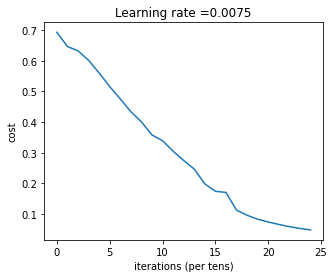

In [ ]:
parameters = two_layer_model(train_x, train_y, layers_dims = (n_x, n_h, n_y), num_iterations = 2500, print_cost=True)

**Kỳ vọng đầu ra**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.6930497356599888 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.6464320953428849 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.048554785628770206 </td>
    </tr>
</table>

Thật tốt khi bạn đã xây dựng được một triển khai vectơ hóa! Nếu không, nó có thể lâu hơn gấp 10 để huấn luyện điều này.

Bây giờ, bạn có thể sử dụng các tham số được huấn luyện để phân loại hình ảnh từ tập dữ liệu. Để xem dự đoán về các tập huấn luyện và thử nghiệm, hãy chạy cell bên dưới.

In [ ]:
predictions_train = predict(train_x, train_y, parameters)

Accuracy: 0.9999999999999998


**Kỳ vọng đầu ra**:
<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 1.0 </td>
    </tr>
</table>

In [ ]:
predictions_test = predict(test_x, test_y, parameters)

Accuracy: 0.72


**Kỳ vọng đầu ra**:

<table> 
    <tr>
        <td> **Accuracy**</td>
        <td> 0.72 </td>
    </tr>
</table>

**Lưu ý**: Bạn có thể thấy rằng việc chạy mô hình với ít lần lặp hơn (ví dụ: 1500) mang lại độ chính xác tốt hơn trên tập thử nghiệm. Điều này được gọi là "early stopping" (dừng sớm) và chúng ta sẽ nói về nó trong các lab tiếp theo. Early stopping là một cách để ngăn ngừa sự quá khớp (overfitting).

Xin chúc mừng! Có vẻ như mạng nơ-ron 2 lớp của bạn có hiệu suất (72%) tốt hơn so với triển khai hồi quy logistic (70%). Hãy xem liệu bạn có thể làm tốt hơn nữa với mô hình $ L $-lớp hay không.

## 5 - Mạng nơ-ron L-lớp

**Câu hỏi**: Sử dụng các hàm trợ giúp mà bạn đã triển khai trước đây để xây dựng mạng nơron $ L $-lớp với cấu trúc sau: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. Các hàm bạn cần và đầu vào là:
```python
def initialize_parameters_deep(layer_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [ ]:
### CONSTANTS ###
layers_dims = [12288, 20, 7, 5, 1] #  5-layer model

In [ ]:
def L_layer_model(X, Y, layers_dims, learning_rate = 0.0075, num_iterations = 3000, print_cost=False):#lr was 0.009
    """
    Triển khai mạng nơ-ron L lớp: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Đối số:
    X -- dữ liệu, mảng numpy có shape (số ví dụ, num_px * num_px * 3)
    Y -- vectơ true "label" (0 nếu là mèo, 1 nếu không phải mèo), có shape (1, số ví dụ)
    layers_dims -- danh sách chứa kích thước đầu vào và từng kích thước lớp có length (số lớp + 1).
    learning_rate -- tốc độ học của quy tắc cập nhật gradient descent
    num_iterations -- số lần lặp của vòng lặp tối ưu hóa
    print_cost -- nếu True, in ra cost sau mỗi 100 lần lặp
    
    Trả về:
    parameters -- các tham số mà mô hình đã tìm hiểu. Chúng sẽ được sử dụng sau để dự đoán.
    """

    np.random.seed(1)
    costs = []                         # theo dõi cost
    
    # Khởi tạo tham số.
    ### BẮT ĐẦU CODE Ở ĐÂY ###
    parameters = initialize_parameters_deep(layers_dims)
    ### KẾT THÚC CODE Ở ĐÂY ###
    
    # Vòng lặp (gradient descent)
    for i in range(0, num_iterations):

        # Lan truyền xuôi: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
        AL, caches = L_model_forward(X, parameters)
        ### KẾT THÚC CODE Ở ĐÂY ###
        
        # Tính cost.
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
        cost = compute_cost(AL, Y)
        ### KẾT THÚC CODE Ở ĐÂY ###
    
        # Lan truyền ngược.
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
        grads = L_model_backward(AL, Y, caches)
        ### KẾT THÚC CODE Ở ĐÂY ###
 
        # Cập nhật tham số.
        ### BẮT ĐẦU CODE Ở ĐÂY ### (≈ 1 dòng code)
        parameters = update_parameters(parameters, grads, learning_rate)
        ### KẾT THÚC CODE Ở ĐÂY ###
                
        # In ra cost sau mỗi 100 ví dụ
        if print_cost and i % 100 == 0:
            print ("Cost after iteration %i: %f" %(i, cost))
        if print_cost and i % 100 == 0:
            costs.append(cost)
            
    # vẽ biểu đồ của cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    
    return parameters

Giờ bạn sẽ huấn luyện mô hình như một mạng nơ-ron 5 lớp.

Chạy cell bên dưới để huấn luyện mô hình của bạn. Cost (mất mát) sẽ giảm ở mỗi lần lặp lại. Có thể mất đến 5 phút để chạy 2500 lần lặp. Kiểm tra xem "Cost after iteration 0" (Mất mát sau lần lặp 0) có khớp với kỳ vọng đầu ra bên dưới hay không; nếu không, hãy nhấp vào ô vuông (⬛) trên thanh trên của notebook để dừng cell và cố gắng tìm lỗi của bạn.

Cost after iteration 0: 0.771749
Cost after iteration 100: 0.672053
Cost after iteration 200: 0.648263
Cost after iteration 300: 0.611507
Cost after iteration 400: 0.567047
Cost after iteration 500: 0.540138
Cost after iteration 600: 0.527930
Cost after iteration 700: 0.465477
Cost after iteration 800: 0.369126
Cost after iteration 900: 0.391747
Cost after iteration 1000: 0.315187
Cost after iteration 1100: 0.272700
Cost after iteration 1200: 0.237419
Cost after iteration 1300: 0.199601
Cost after iteration 1400: 0.189263
Cost after iteration 1500: 0.161189
Cost after iteration 1600: 0.148214
Cost after iteration 1700: 0.137775
Cost after iteration 1800: 0.129740
Cost after iteration 1900: 0.121225
Cost after iteration 2000: 0.113821
Cost after iteration 2100: 0.107839
Cost after iteration 2200: 0.102855
Cost after iteration 2300: 0.100897
Cost after iteration 2400: 0.092878


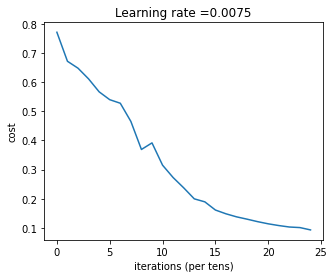

In [ ]:
parameters = L_layer_model(train_x, train_y, layers_dims, num_iterations = 2500, print_cost = True)

**Kỳ vọng đầu ra**:
<table> 
    <tr>
        <td> **Cost after iteration 0**</td>
        <td> 0.771749 </td>
    </tr>
    <tr>
        <td> **Cost after iteration 100**</td>
        <td> 0.672053 </td>
    </tr>
    <tr>
        <td> **...**</td>
        <td> ... </td>
    </tr>
    <tr>
        <td> **Cost after iteration 2400**</td>
        <td> 0.092878 </td>
    </tr>
</table>

In [ ]:
pred_train = predict(train_x, train_y, parameters)

Accuracy: 0.9856459330143539


<table>
    <tr>
    <td>
    **Train Accuracy**
    </td>
    <td>
    0.985645933014
    </td>
    </tr>
</table>

In [ ]:
pred_test = predict(test_x, test_y, parameters)

Accuracy: 0.8


**Kỳ vọng đầu ra**:

<table> 
    <tr>
        <td> **Test Accuracy**</td>
        <td> 0.8 </td>
    </tr>
</table>

Chúc mừng! Có vẻ như mạng nơ-ron 5 lớp của bạn có hiệu suất (80%) tốt hơn so với mạng nơ-ron 2 lớp (72%) trên cùng một tập thử nghiệm.

Nhiệm vụ này có hiệu suất tốt. Bạn làm tốt lắm!

Mặc dù trong lab tiếp theo về "Cải thiện mạng nơ-ron sâu", bạn sẽ học cách đạt được độ chính xác cao hơn nữa bằng cách tìm kiếm các siêu tham số tốt hơn một cách có hệ thống (learning_rate, layer_dims, num_iterations và những thứ khác bạn cũng sẽ học trong lab tiếp theo).

##  6) Phân tích kết quả

Đầu tiên, chúng ta hãy xem những hình ảnh mà mô hình L-lớp được dán nhãn không chính xác. Điều này sẽ hiển thị một vài hình ảnh bị dán nhãn sai. 

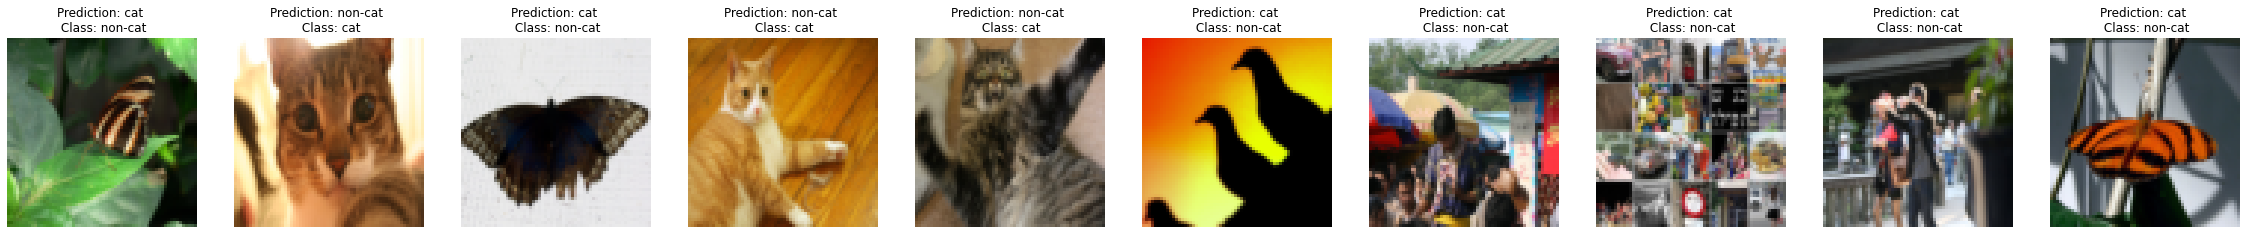

In [ ]:
print_mislabeled_images(classes, test_x, test_y, pred_test)

**Một số loại hình ảnh mà mô hình có xu hướng hoạt động kém bao gồm:** 
- Cơ thể mèo ở vị trí bất thường
- Mèo xuất hiện trên nền có màu tương tự
- Màu sắc và loài mèo khác thường
- Góc máy ảnh
- Độ sáng của hình ảnh
- Thay đổi tỷ lệ (trong hình, mèo rất lớn hoặc nhỏ)

## 7) Kiểm tra với hình ảnh của bạn (tác vụ tùy chọn) ##

Chúc mừng bạn đã hoàn thành lab này. Bạn có thể sử dụng hình ảnh của mình và xem đầu ra mô hình của bạn. Để làm việc đó:
    1. Thêm hình ảnh của bạn vào directory của Jupyter Notebook này, trong folder "images"
    2. Thay đổi tên hình ảnh của bạn trong code sau
    3. Chạy code và kiểm tra xem thuật toán có đúng không (1 = cat, 0 = non-cat)!

In [59]:
## BẮT ĐẦU CODE Ở ĐÂY ##
my_image = "my_image.jpg" # đổi tên file ảnh
my_label_y = [1] # lớp đúng của ảnh (1 -> cat, 0 -> non-cat)
## KẾT THÚC CODE Ở ĐÂY ##

fname = "images/" + my_image
image = np.array(ndimage.imread(fname, flatten=False))
my_image = scipy.misc.imresize(image, size=(num_px,num_px)).reshape((num_px*num_px*3,1))
my_predicted_image = predict(my_image, my_label_y, parameters)

plt.imshow(image)
print ("y = " + str(np.squeeze(my_predicted_image)) + ", your L-layer model predicts a \"" + classes[int(np.squeeze(my_predicted_image)),].decode("utf-8") +  "\" picture.")

AttributeError: module 'scipy.ndimage' has no attribute 'imread'

**Tham khảo**:

- Để tự động tải lại mô-đun bên ngoài: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython